### Structure of the document


For the detailed description of the document see file 'A_no1_preprocessing'. The file contains
1. Import of fermentation data
2. Data Preprocessing
3. Saving the data as .csv file (--> data\batch_no2\data_combined.csv)
4. Data Visualization (--> images\batch_no2_exp.png)

### Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

pd.options.mode.chained_assignment = None  # Suppress the warning

**1. Import experimental data**

In [2]:
# Temperature
df_T=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Temperature_Value.csv', sep=';')
# Stirring
df_stir=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Stirrer_Value.csv', sep=';')
# Feed of Glucose
df_feed1=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Feed 1_Value.csv', sep=';')
# Base & Acid
df_base=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Pump - Base_Value.csv', sep=';')
df_acid=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Pump - Acid_Value.csv', sep=';')
# dissolved O2
df_pO2=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_pO₂_Value.csv', sep=';')
# pH
df_pH=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_pH_Value.csv', sep=';')
# Air feed
df_air=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Flow - Air_Value.csv', sep=';')
# Offgas analysis
df_offgas = pd.read_excel('data/batch_no2/raw data/offgas_data.xlsx')
# Biomass & Glucose concentration
df_X_S = pd.read_csv('data/batch_no2/raw data/offline_data.csv', sep=';')
# Glucose concentration from hplc & sensor
df_S_extract = pd.read_excel('data/batch_no2/raw data/data_S_sensor_extracted.xlsx')
df_S_smoothed = pd.read_excel('data/batch_no2/raw data/data_S_sensor_smoothed.xlsx')
df_S_calibrated1= pd.read_excel('data/batch_no2/raw data/data_S_sensor_calibrated.xlsx')
df_S_hplc = pd.read_csv('data/batch_no2/raw data/data_S_hplc.csv', sep=';')

**2. Data Preprocessing**

In [3]:
# group the dataframes -- acid and base will be pre-processed differently
first_para=[df_T, df_stir, df_feed1, df_pO2, df_pH, df_air]
second_para=[df_base, df_acid]

In [4]:
# Define start and end time of the fermentation
start = '12-07-2023 19:00:00' # originally 12-07-2023 18:30:00 but the sensors clock was 30min in advance
end = '14-07-2023 9:30:00'
start_time = datetime.strptime(start, '%d-%m-%Y %H:%M:%S')
end_time = datetime.strptime(end, '%d-%m-%Y %H:%M:%S')

In [5]:
# first group of parameters: mean value assigned to minute

# dataframes are prepared to be merged into one dataframe based on the timestamp
df_merged1=pd.DataFrame()

for df in first_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # measurement values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the temporal alignment easier
    ## mean value of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').mean() # could be changed to sum/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] <= end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged1.empty:
        df_merged1=df_se
    else:
        df_merged1=df_merged1.merge(df_se, on='DateTime', how='inner')

Second parameter group (sum for reduction of sampling frequency):

In [6]:
# second group of parameters: sum of values assigned to minute

# dataframes are prepared to be merged into one dataframe based on the timestamp
# since the feed of base/acid lasts only a few seconds, data will be lost if we take the first value
## instead we take the sum of the values within that minute and then later divide it by 2/60
df_merged2=pd.DataFrame()

for df in second_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # measurement values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the temporal alignment easier
    ## sum of values of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').sum() # could be changed to sum/mean/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] <= end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged2.empty:
        df_merged2=df_se
    else:
        df_merged2=df_merged2.merge(df_se, on='DateTime', how='inner')

In [7]:
# merging the 2 dataframes
df_merged3 = df_merged1.copy()
df_merged3 = df_merged3.merge(df_merged2, on='DateTime', how='inner')

Merge offgas to the other parameters.

In [8]:
# merge offgas values to the other parameters
# same preprocessing as the others
df_offgas.drop(['time [h]'], axis=1, inplace=True) #
# reduce sample frequency to 1min which makes the temporal alignment easier
## mean value of each minute is taken
df_offgas.set_index('Time&Date', inplace=True)
df_resampled = df_offgas.resample('1T').first() # could be changed to sum/mean/first/min/max...
df_resampled.reset_index(drop=False, inplace=True)
df_resampled.rename(columns={'Time&Date': 'DateTime'}, inplace=True)

# dataframe is reduced to the start and end time of the fermentation
df_offg=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] <= end_time)]

In [9]:
# all continuously measured parameters are combined in one dataframe
# add process duration in hours as time [h]
df_merged4=df_merged3.merge(df_offg, on='DateTime', how='inner')
first_timestamp = df_merged4['DateTime'].iloc[0]  # Get the first timestamp
df_merged4['time [h]'] = (df_merged4['DateTime'] - first_timestamp) / pd.Timedelta(hours=1)
df_merged4['time [h]'] = df_merged4['time [h]'].round(2)
# rename column names to clear descriptions with units
df_merged4.rename(columns={'Temperature Value (°C)': 'Temperature [°C]', 'Stirrer Value (rpm)': 'Stirrer [rpm]', 'pO₂ Value (pO₂)': 'DO2 [%]'}, errors='raise', inplace=True)
df_merged4.rename(columns={'CO2 [%]': 'Offgas CO2 [%]', 'O2 [%]': 'Offgas O2 [%]'}, errors='raise', inplace=True)
df_merged4.head(1)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas O2 [%],Offgas CO2 [%],time [h]
0,2023-07-12 19:01:00,29.902727,193.487273,0.0,79.528,6.94,0.0,0.0,0.0,NaN,NaN,0.0


In [10]:
# preprocess biomass data which is not continuous but from samples
df_biomass = df_X_S[['time [h]', 'BM (g/l)']]
for col in df_biomass.columns:
    df_biomass[col]=df_biomass[col].str.replace(',', '.')
    df_biomass[col]=pd.to_numeric(df_biomass[col])
df_biomass.rename(columns={'BM (g/l)': 'Biomass [g/L]'}, inplace=True)
# add last measurement
df_biomass.loc[df_biomass['time [h]'] == 37.5, 'time [h]'] = 35.75
df_biomass.head(1)

,time [h],Biomass [g/L]
0,0.75,0.38


In [11]:
# preprocess glucose hplc measurement data which is not continuous but from samples
df_hplc = df_S_hplc[['time [h]', 'glucose 2 [g/l]']]
for col in df_hplc.columns:
     df_hplc[col] = df_hplc[col].str.replace(',', '.')
     df_hplc[col] = pd.to_numeric(df_hplc[col])
df_hplc.rename(columns={'glucose 2 [g/l]': 'Glucose hplc [g/L]'}, inplace=True)
df_hplc.head(2)

,time [h],Glucose hplc [g/L]
0,0.75,8.5
1,13.25,0.0


In [12]:
# merging the biomass, glucose and all other parameters to the overall dataframe which is called df
df = df_merged4.merge(df_biomass, on='time [h]', how='left')
df = df.merge(df_hplc, on='time [h]', how='left')
df.head(1)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas O2 [%],Offgas CO2 [%],time [h],Biomass [g/L],Glucose hplc [g/L]
0,2023-07-12 19:01:00,29.902727,193.487273,0.0,79.528,6.94,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN


Final dataframe created. Now, outlier removal and feature extraction:

In [13]:
df['Feed 1 Value (%)'] = df['Feed 1 Value (%)']/(10*1000)
df.loc[df['time [h]'] < 20.1, 'Feed 1 Value (%)'] = 0
df.rename(columns={'Feed 1 Value (%)': 'Glucose feed [L/min]'}, inplace=True)

# Feed 1 contains 350 g/L glucose so a new parameter with the feed rate in g/h is added
df['Glucose feed [g/h]'] = df['Glucose feed [L/min]']*350*60
df['Glucose added [g/min]'] = df['Glucose feed [L/min]'] * 350
df['Glucose added [g/min]'] = df['Glucose added [g/min]'].cumsum().add(40)

In [14]:
# one feed of base/acid lasts for max 2s. Since we have samples every minute I divided the value of the feed rate by 30 because I multiply by 2s*1/60s
df['Pump - Base Value (%)']=df['Pump - Base Value (%)']/(30*10*1000)
df['Pump - Acid Value (%)']=df['Pump - Acid Value (%)']/(30*10*1000)
df.rename(columns={'Pump - Base Value (%)': 'Pump - Base [L/min]', 'Pump - Acid Value (%)': 'Pump - Acid [L/min]', 'Flow - Air Value': 'Air feed [mL/min]'}, inplace=True)

# renamed 'Flow - Air Value' to 'Air feed [mL/min]' in Line 4 of this box eventhough it was not converted yet
df['Air feed [mL/min]']=df['Air feed [mL/min]']/10

In [15]:
# assumption that air_in is equal to air_out
df['Offgas CO2 [mL/min]'] = df['Air feed [mL/min]'] * df['Offgas CO2 [%]']/100
density_co2 = 1.9767 # kg/m^3 or g/L at 20 degreeC
df['Offgas CO2 [g/min]']=(df['Offgas CO2 [mL/min]']/1000)*density_co2
df['Offgas CO2 [g/L]']= df['Offgas CO2 [g/min]']/(df['Air feed [mL/min]']/1000)

In [16]:
# since the fermentation is fed-batch, the volume increases with time but sampling reduces the volume
## start volume is 4L
## in total 13x20mL = 260mL were taken out by sampling
## in order to make it a continuous reduction it is divided by the total number of timestemps
df['Feed total [L/min]']=df['Glucose feed [L/min]'] + df['Pump - Base [L/min]'] + df['Pump - Acid [L/min]'] - 0.26/2215
df['Volume [L]']=df['Feed total [L/min]'].cumsum().add(4)
# Volume calculation is missing evaporation term - since no weight measurements, it is not included so far (no way to check if it is correct)
df['Volume [L]'].max()

4.4675940599493815

In [17]:
# dissolved oxygen and stirring fluctuate a lot so exponential smooting is applied
df['Stirrer [rpm]- smoothed'] = df['Stirrer [rpm]'].ewm(alpha=0.1).mean()
df['DO2 [%]- smoothed'] = df['DO2 [%]'].ewm(alpha=0.1).mean()

# new parameters are added
df['OUR [%/(Lh)]'] = ((df['Offgas O2 [%]']-df['Offgas O2 [%]'][1])/df['Volume [L]'])/(df['time [h]'])
df['CER [%/(Lh)]'] = ((df['Offgas CO2 [%]']-df['Offgas CO2 [%]'][1])/df['Volume [L]'])/(df['time [h]'])
df['RQ'] = (df['CER [%/(Lh)]'] / df['OUR [%/(Lh)]'])*(-1)

df.sort_index(axis=1, inplace=True)

**3. Save dataframe as .csv file**

In [18]:
# save dataframe as csv files
df.to_csv('data/batch_no2/data_combined.csv')

**4. Data Visualization**

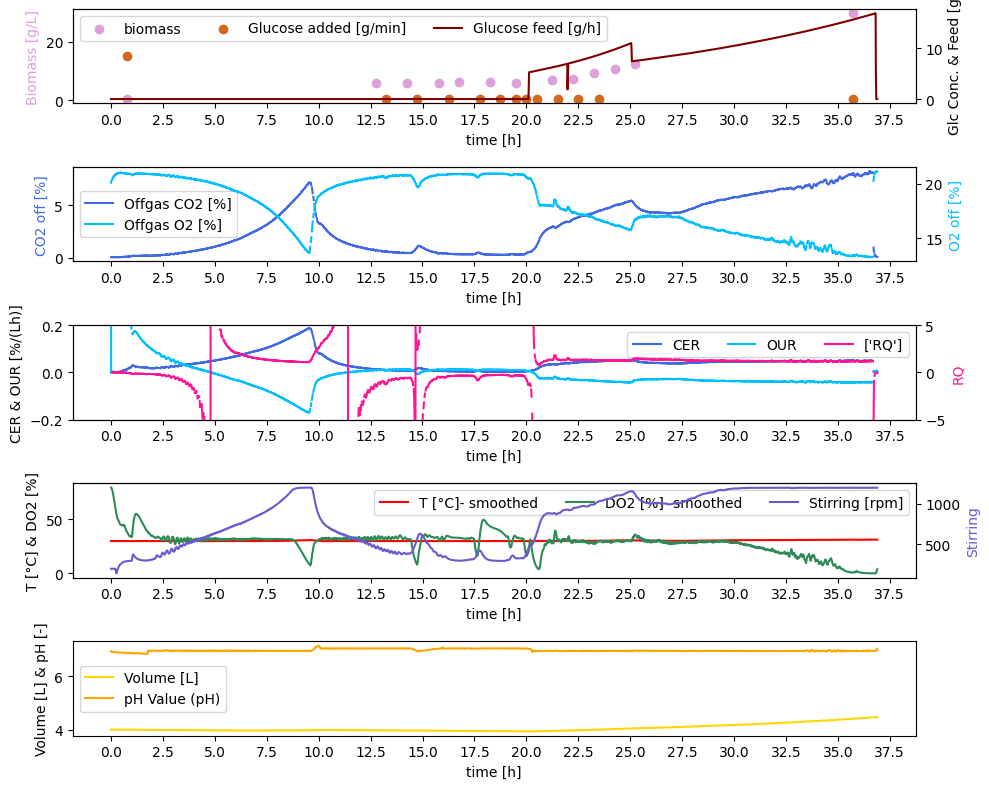

In [19]:
fig, ax = plt.subplots(5,1, figsize=(10,8))

ax[0].scatter(df['time [h]'], df['Biomass [g/L]'], label='biomass', color='plum')
ax0 = ax[0].twinx()
ax0.scatter(df['time [h]'], df['Glucose hplc [g/L]'], label='Glucose added [g/min]', color='chocolate')
ax0.plot(df['time [h]'], df['Glucose feed [g/h]'], label='Glucose feed [g/h]', color='maroon')

ax[1].plot(df['time [h]'], df['Offgas CO2 [%]'], label='Offgas CO2 [%]', color='royalblue')
ax1 = ax[1].twinx()
ax1.plot(df['time [h]'], df['Offgas O2 [%]'], label='Offgas O2 [%]', color='deepskyblue')

ax[2].plot(df['time [h]'], df['CER [%/(Lh)]'], label='CER', color='royalblue')
ax[2].plot(df['time [h]'], df['OUR [%/(Lh)]'], label='OUR', color='deepskyblue')
ax[2].set_ylim(-0.2,0.2)
ax2 = ax[2].twinx()
ax2.plot(df['time [h]'],df['RQ'], label=['RQ'], color='deeppink')
ax2.set_ylim(-5,5)

ax[3].plot(df['time [h]'], df['Temperature [°C]'], label='T [°C]- smoothed', color='red')
ax[3].plot(df['time [h]'], df['DO2 [%]- smoothed'], label='DO2 [%]- smoothed', color='seagreen')
ax3 = ax[3].twinx()
ax3.plot(df['time [h]'], df['Stirrer [rpm]- smoothed'], label='Stirring [rpm]', color='slateblue')

ax[4].plot(df['time [h]'], df['Volume [L]'], label='Volume [L]', color='gold')
ax[4].plot(df['time [h]'], df['pH Value (pH)'], label='pH Value (pH)', color='orange')

ax[0].set_xlabel('time [h]'); ax[0].set_ylabel('Biomass [g/L]', color='plum')
ax0.set_ylabel('Glc Conc. & Feed [g/L]')
ax[0].locator_params(axis='x', nbins=20)

ax[1].set_xlabel('time [h]'); ax[1].set_ylabel('CO2 off [%]', color='royalblue')
ax1.set_ylabel('O2 off [%]', color='deepskyblue')
ax[1].locator_params(axis='x', nbins=20)

ax[2].set_xlabel('time [h]'); ax[2].set_ylabel('CER & OUR [%/(Lh)]')
ax2.set_ylabel('RQ', color='deeppink')
ax[2].locator_params(axis='x', nbins=20)

ax[3].set_xlabel('time [h]'); ax[3].set_ylabel('T [°C] & DO2 [%]')
ax3.set_ylabel('Stirring', color='slateblue')
ax[3].locator_params(axis='x', nbins=20)

ax[4].set_xlabel('time [h]'); ax[4].set_ylabel('Volume [L] & pH [-]')
ax[4].locator_params(axis='x', nbins=20)

h_0, l_0 = ax[0].get_legend_handles_labels()
h0, l0 = ax0.get_legend_handles_labels()
handles_0 = h_0 + h0; labels_0 = l_0 + l0
ax[0].legend(handles_0, labels_0, loc='upper left', ncols=3)

h_1, l_1 = ax[1].get_legend_handles_labels()
h1, l1 = ax1.get_legend_handles_labels()
handles_1 = h_1 + h1; labels_1 = l_1 + l1
ax[1].legend(handles_1, labels_1, loc='center left')

h_2, l_2 = ax[2].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
handles_2 = h_2 + h2; labels_2 = l_2 + l2
ax[2].legend(handles_2, labels_2, ncols=3)

h_3, l_3 = ax[3].get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()
handles_3 = h_3 + h3; labels_3 = l_3 + l3
ax[3].legend(handles_3, labels_3, ncols=3)

handles_4, labels_4 = ax[4].get_legend_handles_labels()
ax[4].legend(handles_4, labels_4, loc='center left')

plt.tight_layout()
plt.show()